In [371]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
from scipy.linalg import eigh
from scipy.signal import hilbert

In [2]:
import pickle

In [3]:
import os
print(os.cpu_count())

8


In [4]:
workes = os.cpu_count()

In [5]:
from datetime import datetime

In [6]:
from concurrent.futures import ThreadPoolExecutor

In [333]:
from fractions import Fraction

In [7]:
with open('/users/jetto/py/通貨先物ポジション/endog0.pkl',mode='rb') as f:
    cot = pickle.load(f)

In [8]:
cot = (cot-cot.mean())/cot.std()
cot.std()

yen                               1.0
AUSTRALIAN DOLLAR                 1.0
BRAZILIAN REAL                    1.0
CANADIAN DOLLAR                   1.0
DJIA Consolidated                 1.0
E-MINI S&P 400 STOCK INDEX        1.0
EURO FX                           1.0
JAPANESE YEN                      1.0
MEXICAN PESO                      1.0
NASDAQ-100 Consolidated           1.0
NIKKEI STOCK AVERAGE YEN DENOM    1.0
S&P 500 ANNUAL DIVIDEND INDEX     1.0
S&P 500 Consolidated              1.0
SWISS FRANC                       1.0
VIX FUTURES                       1.0
fcm1                              1.0
fcm2                              1.0
fcm10                             1.0
dtype: float64

In [9]:
cot.max()

yen                               3.314928
AUSTRALIAN DOLLAR                 4.815787
BRAZILIAN REAL                    4.111405
CANADIAN DOLLAR                   3.215468
DJIA Consolidated                 4.567605
E-MINI S&P 400 STOCK INDEX        2.697403
EURO FX                           5.013099
JAPANESE YEN                      4.168952
MEXICAN PESO                      2.802613
NASDAQ-100 Consolidated           5.526056
NIKKEI STOCK AVERAGE YEN DENOM    4.644417
S&P 500 ANNUAL DIVIDEND INDEX     2.507175
S&P 500 Consolidated              4.848279
SWISS FRANC                       4.280003
VIX FUTURES                       2.529198
fcm1                              3.909248
fcm2                              3.254252
fcm10                             2.883319
dtype: float64

In [10]:
cot.min()

yen                               -3.444112
AUSTRALIAN DOLLAR                 -3.110821
BRAZILIAN REAL                    -3.721989
CANADIAN DOLLAR                   -7.990826
DJIA Consolidated                 -4.282103
E-MINI S&P 400 STOCK INDEX        -6.876413
EURO FX                           -3.520889
JAPANESE YEN                      -3.808073
MEXICAN PESO                      -7.392449
NASDAQ-100 Consolidated           -5.747608
NIKKEI STOCK AVERAGE YEN DENOM    -4.636580
S&P 500 ANNUAL DIVIDEND INDEX    -11.062323
S&P 500 Consolidated             -12.440144
SWISS FRANC                       -3.834897
VIX FUTURES                       -3.694415
fcm1                              -6.510466
fcm2                              -6.627684
fcm10                             -3.308393
dtype: float64

In [11]:
#data = cot.loc[:,['yen','fcm1','fcm10']].copy()
data = cot.copy()

In [99]:
T,N = data.shape
data.shape

(324, 18)

### ヒルベルト変換(固有値は大きい順にソート)

In [261]:
def make_hilvert(arg_data):
    analytic_s = hilbert(arg_data, axis=0)
    C_ = analytic_s.conj().T.dot(analytic_s)/T
    arg_evals, arg_evecs = np.linalg.eig(C_)
    idx = np.real(arg_evals).argsort()[::-1]
    arg_evals = (np.real(arg_evals))[idx]
    arg_evecs = arg_evecs[:,idx]
    arg_evecs = pd.DataFrame(arg_evecs)
    arg_evecs.index=list(arg_data.columns)
    return arg_evals,arg_evecs

In [262]:
eigenvals, eigenvecs = make_hilvert(data)
np.real(eigenvals)

array([6.51235426, 3.52407477, 3.19420841, 2.9016504 , 2.43029286,
       2.27061255, 2.11693134, 1.89639082, 1.72266354, 1.61534297,
       1.40836605, 1.28486114, 1.21874202, 1.11475213, 0.99417997,
       0.8858704 , 0.57542253, 0.16225723])

### 実部は元のデータであることを確認

In [259]:
print(data.iloc[0,0],analytic_signal[0,0])

-1.632895826352142 (-1.6328958263521423+0.6207341499328829j)


### 累積寄与率

In [260]:
pd.DataFrame(eigenvals.cumsum() / eigenvals.sum()).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0.181762,0.28012,0.369272,0.450258,0.518089,0.581462,0.640547,0.693476,0.741556,0.786641,0.825949,0.861809,0.895825,0.926938,0.954686,0.979411,0.995471,1.0


### 固有ベクトル

In [263]:
eigenvecs.iloc[:,0]

yen                               0.389647+0.020521j
AUSTRALIAN DOLLAR                -0.048066+0.132312j
BRAZILIAN REAL                   -0.060086+0.006693j
CANADIAN DOLLAR                  -0.033542+0.144879j
DJIA Consolidated                 0.024734+0.049810j
E-MINI S&P 400 STOCK INDEX       -0.097094+0.017401j
EURO FX                           0.039123-0.068544j
JAPANESE YEN                      0.095175-0.082530j
MEXICAN PESO                      0.127985-0.054724j
NASDAQ-100 Consolidated           0.052908+0.102005j
NIKKEI STOCK AVERAGE YEN DENOM    0.103961+0.037532j
S&P 500 ANNUAL DIVIDEND INDEX    -0.004980+0.010187j
S&P 500 Consolidated              0.017984+0.142445j
SWISS FRANC                       0.165348+0.096536j
VIX FUTURES                       0.083778-0.010273j
fcm1                              0.466335+0.031762j
fcm2                              0.494917+0.000000j
fcm10                             0.440903-0.010404j
Name: 0, dtype: complex128

### RRSの実装

In [18]:
def rotational_shuffle(arg_data):
    """
    データを変数ごとに回転的にシャッフルします。
    data: 時系列データ（時間が行、変数が列）
    """
    N, num_vars = arg_data.shape  # Nは時系列の長さ、num_varsは変数の数
    shuffled_data = pd.DataFrame(np.empty_like(arg_data),columns=list(arg_data.columns))
    
    for var in list(arg_data.columns):
        tau = np.random.randint(0, N-2)  # 変数ごとに異なるランダムオフセットtauを生成
        shuffled_data.loc[:, var] = np.roll(arg_data.loc[:, var], -tau)
    
    return shuffled_data

In [256]:
def process_shuffled_data(arg_data):
    shuffled = rotational_shuffle(arg_data)
    shuffled_eigenvals, _ = make_hilvert(shuffled)
    return np.sort(np.real(shuffled_eigenvals))[::-1]

### 検定

In [ ]:
zero = datetime.now()
sim_num = 100000
input_data = data

### RRSを並列処理で

In [125]:

# ThreadPoolExecutorを使用して処理を並列実行
with ThreadPoolExecutor(max_workers=workes) as executor:
    futures = [executor.submit(process_shuffled_data, input_data) for _ in range(sim_num)]
    results = [f.result() for f in futures]

print('終わりました：',datetime.now()-zero)

終わりました： 0:09:20.139477


##### (max_worker=8,sim_num=1e5,フル変数)終わりました： 0:09:18.271443
##### (max_worker=8,sim_num=1e4)終わりました： 0:00:05.188745
##### (max_worker=8,sim_num=1e5)終わりました： 0:00:50.983506

### RRSを直接処理で

In [148]:
zero = datetime.now()
results = []
for i in range(sim_num):
    results += [process_shuffled_data(input_data)]
print('終わりました：',datetime.now()-zero)

終わりました： 0:06:20.998461


In [149]:
eigenval_distribution = pd.DataFrame(results)
eigenval_mean = pd.DataFrame(eigenval_distribution.mean()).T
eigenval_std = pd.DataFrame(eigenval_distribution.std()).T
thresholds = (eigenval_mean + 3 * eigenval_std).T
thresholds.columns = ['RRS']
thresholds.T 

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
RRS,3.703291,3.270353,3.021689,2.823882,2.652844,2.500241,2.361692,2.232833,2.111402,1.996589,1.88684,1.781141,1.676083,1.574906,1.475064,1.374261,1.27352,1.240835


### RMT

In [150]:
# Q と λ の計算
Q = T / (2 * N)
lambda_upp = (1 + np.sqrt(1/Q))**2
lambda_upp

1.7777777777777777

### 検定

In [155]:
eigenvals = pd.DataFrame(eigenvals)
eigenvals.columns = ['actual']
chk = pd.concat([eigenvals,thresholds],axis=1)
chk['RTM'] = lambda_upp
chk.loc[:,'RRS_chk']=(chk.loc[:,'actual']>chk.loc[:,'RRS'])
chk.loc[:,'RMT_chk']=(chk.loc[:,'actual']>chk.loc[:,'RRS'])
chk = chk[(chk['RRS_chk']==True)|(chk['RMT_chk']==True)]
chk

,actual,RRS,RTM,RRS_chk,RMT_chk
0,6.512354,3.703291,1.777778,True,True
1,3.524075,3.270353,1.777778,True,True
2,3.194208,3.021689,1.777778,True,True
3,2.901650,2.823882,1.777778,True,True


### 固有ベクトル成分のプロット

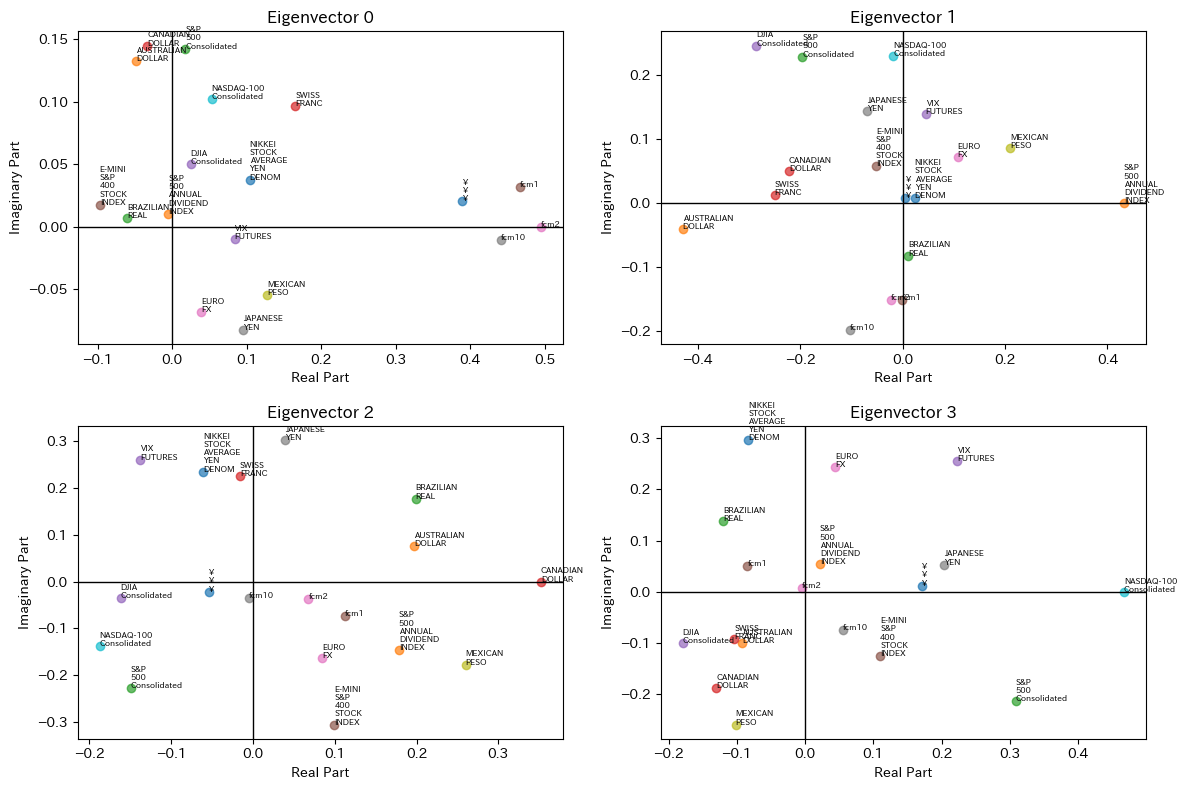

In [286]:
# 固有ベクトルの成分を複素平面にプロット
variable_names = list(eigenvecs.index)
variable_namesX = [s if not s=='yen' else '¥ ¥ ¥' for s in variable_names]

cols = 2  # 1行あたりのサブプロットの数
rows = chk.shape[0] // cols + (chk.shape[0] % cols > 0)  # 必要な行数

plt.figure(figsize=(12, rows * 4))

k = 0
for i in list(chk.index):  # 各固有ベクトルに対して
    plt.subplot(rows, cols, k + 1)  # サブプロットの位置を指定
    vec = eigenvecs.loc[:,i].values    
    for j in range(vec.shape[0]):
        plt.scatter(vec[j].real, vec[j].imag, alpha=0.7)
        plt.text(vec[j].real,
                 vec[j].imag,
                 variable_namesX[j].replace(' ','\n'),
                 fontsize=6)

    # 座標軸の表示
    plt.xlabel('Real Part')
    plt.ylabel('Imaginary Part')
    plt.axhline(0, color='black', linewidth=1)
    plt.axvline(0, color='black', linewidth=1)
    plt.title(f'Eigenvector {i}')

    k += 1
    
plt.tight_layout()
plt.savefig('img/主要固有ベクトルの成分分布.png')
plt.show()


### 主成分ベクトルの要素の有意水準を計算

In [336]:
rng = np.random.default_rng() #　平均ゼロ、標準偏差１の乱数
dataX = data.copy()
for i in range(10000):
    dataX.loc[:,'rand'] = rng.standard_normal(dataX.shape[0])
    _,evecs = make_hilvert(dataX)
    evecs = evecs.iloc[:,:-1].values
    if i == 0:
        sig = evecs
    else:
        sig = np.dstack([sig,evecs])

#### 19行目が乱数部

In [347]:
sig = np.abs(sig)

In [351]:
sig_mean = sig.mean(axis=2)
sig_std = sig.std(axis=2)
sig_mean.shape

(19, 18)

In [420]:
pd.DataFrame(sig_mean[-1,:]+2*sig_std[-1,:]).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0.114727,0.284907,0.306503,0.336813,0.627977,0.455453,0.456344,0.599122,0.538904,0.401861,0.539812,0.340939,0.238865,0.325486,0.322795,0.275532,0.26881,0.135687


### 各固有ベクトル成分の位相を計算

In [247]:
phase = pd.DataFrame(np.angle(eigenvecs))
phase.index = list(data.columns)
phase = phase / np.pi
abs = np.abs(eigenvecs)

In [248]:
phase.iloc[:,:2]

,0,1
yen,0.016748,0.302292
AUSTRALIAN DOLLAR,0.610917,-0.970070
BRAZILIAN REAL,0.964690,-0.455821
CANADIAN DOLLAR,0.572419,0.928394
DJIA Consolidated,0.353291,0.773118
E-MINI S&P 400 STOCK INDEX,0.943553,0.733388
EURO FX,-0.334908,0.187392
JAPANESE YEN,-0.227388,0.643310
MEXICAN PESO,-0.128616,0.123085
NASDAQ-100 Consolidated,0.347695,0.525709


In [427]:
def make_phase(arg_eigenvecs,arg_var):
    new_phases = []
    new_mags = []
    for i in range(arg_eigenvecs.shape[1]):  # 列（固有ベクトル）ごとにループ
        arg_vec = arg_eigenvecs.iloc[:, i]  # i番目の固有ベクトル
        arg_phases = np.angle(arg_vec)  # 位相を計算
        arg_magnitudes = np.abs(arg_vec)  # 絶対値を計算

        # 基準成分の選択（例えば、0番目の成分）と相対的な位相の調整
        pos = variable_names.index(arg_var)
        reference_phase = arg_phases[pos]
        relative_phases = arg_phases - reference_phase
        # [-π, π]の範囲に調整
        relative_phases = np.mod(relative_phases + np.pi, 2 * np.pi) - np.pi
        
        # 反相関の閾値を定義
        for j, phase in enumerate(relative_phases):
            # 反相関成分の判定と処理
            if np.isclose(phase, np.pi, atol=1e-2):  # atolは許容誤差
                relative_phases[j] = (phase + np.pi) % (2 * np.pi) - np.pi
                arg_magnitudes[j] *= -1
        new_phases += [relative_phases/np.pi]
        new_mags += [arg_magnitudes]

    new_phases = pd.DataFrame(new_phases).T
    new_phases.index = variable_names
    new_mags = pd.DataFrame(new_mags).T

    return new_phases, new_mags

In [428]:
phase,mags = make_phase(eigenvecs,'yen')

In [430]:
pd.DataFrame(phase[0]).T

,yen,AUSTRALIAN DOLLAR,BRAZILIAN REAL,CANADIAN DOLLAR,DJIA Consolidated,E-MINI S&P 400 STOCK INDEX,EURO FX,JAPANESE YEN,MEXICAN PESO,NASDAQ-100 Consolidated,NIKKEI STOCK AVERAGE YEN DENOM,S&P 500 ANNUAL DIVIDEND INDEX,S&P 500 Consolidated,SWISS FRANC,VIX FUTURES,fcm1,fcm2,fcm10
0,0.0,0.594169,0.947942,0.55567,0.336543,0.926805,-0.351656,-0.244137,-0.145364,0.330946,0.093533,0.627996,0.443275,0.151462,-0.055586,0.004899,-0.016748,-0.024258


In [431]:
pd.DataFrame(original_phase[0]).T

,yen,AUSTRALIAN DOLLAR,BRAZILIAN REAL,CANADIAN DOLLAR,DJIA Consolidated,E-MINI S&P 400 STOCK INDEX,EURO FX,JAPANESE YEN,MEXICAN PESO,NASDAQ-100 Consolidated,NIKKEI STOCK AVERAGE YEN DENOM,S&P 500 ANNUAL DIVIDEND INDEX,S&P 500 Consolidated,SWISS FRANC,VIX FUTURES,fcm1,fcm2,fcm10
0,0.0,0.594169,0.947942,0.55567,0.336543,0.926805,-0.351656,-0.244137,-0.145364,0.330946,0.093533,0.627996,0.443275,0.151462,-0.055586,0.004899,-0.016748,-0.024258


In [330]:
mags.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
yen,0.390187,0.009752,0.057750,0.172188,0.061278,0.149994,0.176732,0.180870,0.132985,0.060159,0.112718,0.081778,0.296164,0.102470,0.322162,0.667810,0.185625,0.036732
AUSTRALIAN DOLLAR,0.140772,0.431298,0.211331,0.136751,0.283226,0.175301,0.183021,0.098202,0.050337,0.134838,0.219865,0.408537,0.014888,0.345251,0.402231,0.210576,0.119060,0.032093
BRAZILIAN REAL,0.060457,0.082955,0.266178,0.183829,0.170633,0.350457,0.497863,0.326893,0.124267,0.496307,0.010924,0.255017,0.039805,0.085042,0.055239,0.045638,0.189450,0.037405
CANADIAN DOLLAR,0.148712,0.227741,0.352134,0.229837,0.373389,0.106546,0.021249,0.196845,0.147158,0.110548,0.450182,0.132866,0.306122,0.125933,0.321158,0.275053,0.127569,0.019749
DJIA Consolidated,0.055613,0.377513,0.165861,0.205519,0.364747,0.102091,0.211687,0.075840,0.436814,0.122062,0.284951,0.220355,0.136465,0.453114,0.043954,0.166189,0.030947,0.026735


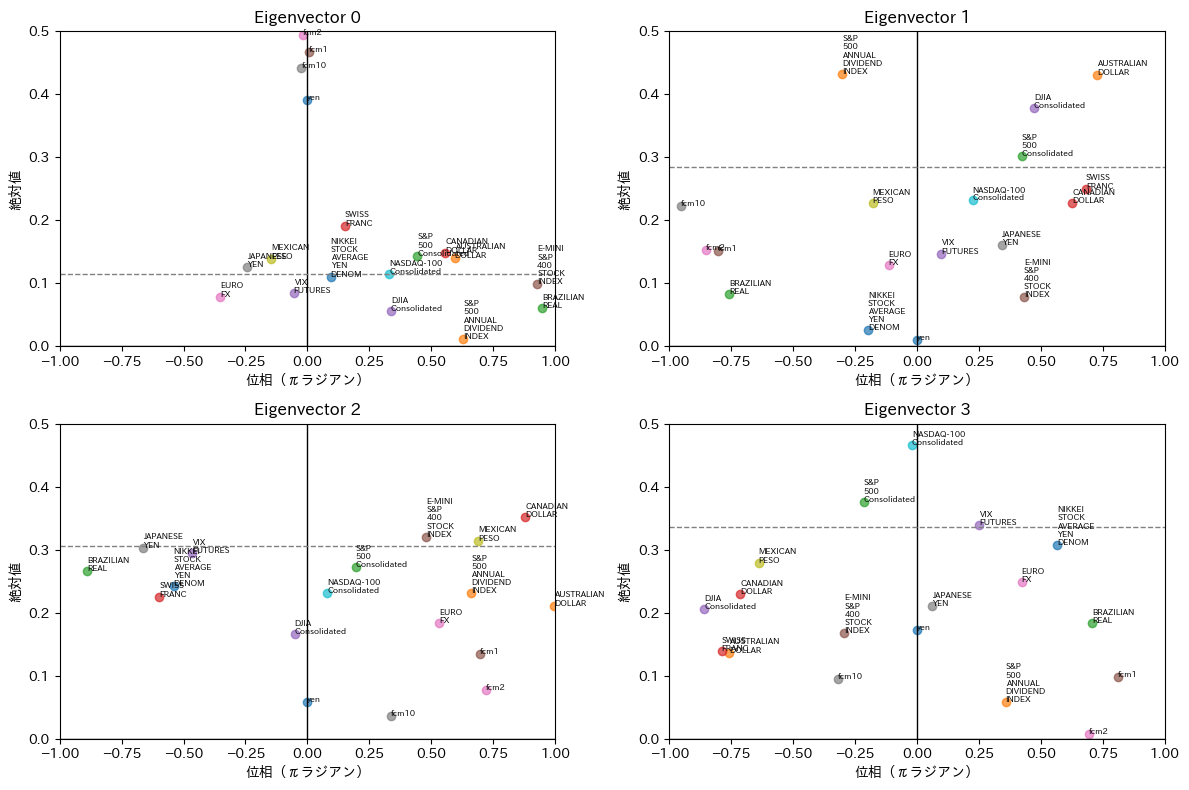

In [413]:
cols = 2  # 1行あたりのサブプロットの数
rows = chk.shape[0] // cols + (chk.shape[0] % cols > 0)  # 必要な行数

plt.figure(figsize=(12, rows * 4))

k = 0
for i in list(chk.index):  # 各固有ベクトルに対して
    plt.subplot(rows, cols, k + 1)  # サブプロットの位置を指定
    x = phase.loc[:,i].values
    y = mags.loc[:,i].values
    for j in range(x.shape[0]):
        plt.scatter(x[j], y[j], alpha=0.7)
        plt.text(x[j], y[j], variable_names[j].replace(' ','\n'), fontsize=6)

    # 座標軸の表示
    plt.xlabel('位相（πラジアン）')
    plt.xlim(-1,1)
    plt.ylim(0,0.5)
    plt.ylabel('絶対値')
    plt.axhline(0, color='black', linewidth=1)
    plt.axvline(0, color='black', linewidth=1)
    # 有意水準の表示 
    plt.axhline(sig_mean[-1,i]+2*sig_std[-1,i], color='gray', linewidth=1, linestyle='dashed')
    plt.title(f'Eigenvector {i}')

    k += 1
    
plt.tight_layout()
plt.savefig('img/強度と位相.png')
plt.show()


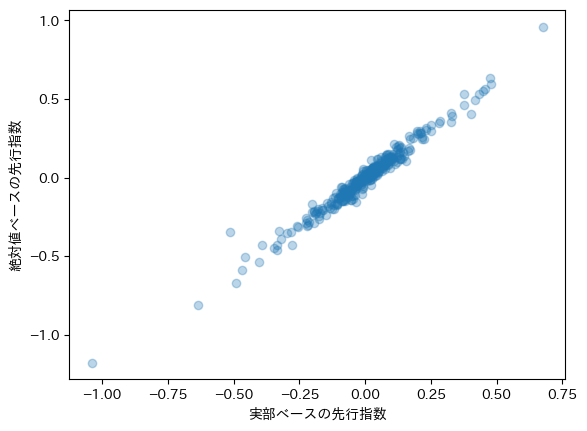

In [415]:

selected_vars = ['JAPANESE YEN','MEXICAN PESO','EURO FX']
leading_real = np.dot(data.loc[:,selected_vars],
                       np.real(eigenvecs.loc[selected_vars,0].values))
leading_real = pd.DataFrame(leading_real)
leading_real.index = list(data.index)

leading_abs = np.dot(data.loc[:,selected_vars],
                       np.abs(eigenvecs.loc[selected_vars,0].values))
leading_abs = pd.DataFrame(leading_abs)
leading_abs.index = list(data.index)

phi = np.imag(eigenvecs.loc[selected_vars,0].values).mean()
phi = (phi / (2 * np.pi)) * 54

plt.scatter(leading_real.values,leading_abs.values,alpha=0.3)
plt.xlabel('実部ベースの先行指数')
plt.ylabel('絶対値ベースの先行指数')
plt.show()

In [410]:
import statsmodels.api as sm

X = leading_abs.shift(int(phi)+1)
X['C'] = 1
temp = pd.concat([data.loc[:,'yen'],X],axis=1).dropna(how='any',axis=0)
temp.columns = ['yen','leading_index','const']
y = temp['yen']
X = temp.iloc[:,1:]

model = sm.OLS(y, X)
res = model.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                    yen   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     3.937
Date:                Sat, 30 Mar 2024   Prob (F-statistic):             0.0481
Time:                        19:26:41   Log-Likelihood:                -455.01
No. Observations:                 323   AIC:                             914.0
Df Residuals:                     321   BIC:                             921.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
leading_index     0.5210      0.263      1.984

In [411]:
X = leading_real.shift(int(phi)+1)
X['C'] = 1
temp = pd.concat([data.loc[:,'yen'],X],axis=1).dropna(how='any',axis=0)
temp.columns = ['yen','leading_index','const']
y = temp['yen']
X = temp.iloc[:,1:]

model = sm.OLS(y, X)
res = model.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                    yen   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     4.140
Date:                Sat, 30 Mar 2024   Prob (F-statistic):             0.0427
Time:                        19:26:55   Log-Likelihood:                -454.90
No. Observations:                 323   AIC:                             913.8
Df Residuals:                     321   BIC:                             921.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
leading_index     0.6681      0.328      2.035

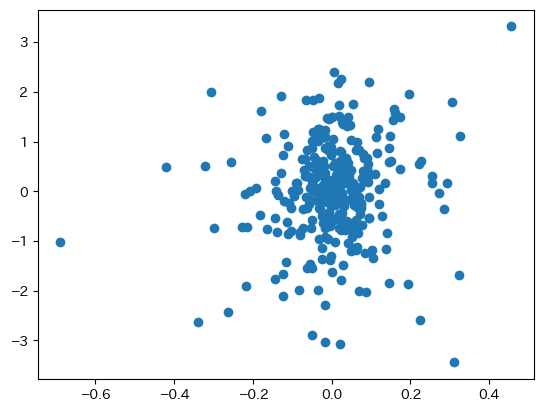

In [412]:
y_ = res.fittedvalues
plt.scatter(y_,y)
plt.show()

### 各成分の有意水準との比較

In [372]:
test = pd.DataFrame()
for i in range(data.shape[1]):
    uu = pd.DataFrame(sig_mean[:-1,i]+2*sig_std[:-1,i])
    ll = pd.DataFrame(sig_mean[:-1,i]-2*sig_std[:-1,i])
    uu.index = variable_names
    ll.index = variable_names
    temp = pd.concat([ll,mags[i],uu],axis=1)
    temp.columns = ['m-2σ','abs','m+2σ']
    temp['chk']=(temp['m-2σ']<temp['abs'])&(temp['abs']<temp['m+2σ'])
    temp.columns = pd.MultiIndex.from_tuples([('Eigenvec: '+str(i),s) for s in list(temp.columns)])
    test = pd.concat([test,temp],axis=1)
test

Eigenvec: 0                            \
                                      m-2σ       abs      m+2σ   chk   
yen                               0.386823  0.390187  0.391948  True   
AUSTRALIAN DOLLAR                 0.136789  0.140772  0.144194  True   
BRAZILIAN REAL                    0.057102  0.060457  0.063608  True   
CANADIAN DOLLAR                   0.144942  0.148712  0.151907  True   
DJIA Consolidated                 0.051938  0.055613  0.059167  True   
E-MINI S&P 400 STOCK INDEX        0.095092  0.098641  0.101837  True   
EURO FX                           0.075513  0.078924  0.082057  True   
JAPANESE YEN                      0.122399  0.125974  0.129079  True   
MEXICAN PESO                      0.135467  0.139193  0.142329  True   
NASDAQ-100 Consolidated           0.111232  0.114909  0.118122  True   
NIKKEI STOCK AVERAGE YEN DENOM    0.107001  0.110528  0.113583  True   
S&P 500 ANNUAL DIVIDEND INDEX     0.007767  0.011339  0.015187  True   
S&P 500 Consolidated              0.139732  0.143576  0.146809  True   
SWISS FRANC                       0.187824  0.191466  0.194314  True   
VIX FUTURES                       0.080777  0.084406  0.087688  True   
fcm1                              0.463870  0.467415  0.469023  True   
fcm2                              0.491392  0.494917  0.496393  True   
fcm10                             0.437467  0.441026  0.442778  True   

                               Eigenvec: 1                            \
                                      m-2σ       abs      m+2σ   chk   
yen                              -0.001956  0.009752  0.030931  True   
AUSTRALIAN DOLLAR                 0.387842  0.431298  0.459329  True   
BRAZILIAN REAL                    0.044989  0.082955  0.123264  True   
CANADIAN DOLLAR                   0.175930  0.227741  0.274312  True   
DJIA Consolidated                 0.336391  0.377513  0.404430  True   
E-MINI S&P 400 STOCK INDEX        0.036938  0.077667  0.122702  True   
EURO FX                           0.093390  0.129352  0.162855  True   
JAPANESE YEN                      0.115038  0.160796  0.203372  True   
MEXICAN PESO                      0.178355  0.227576  0.270699  True   
NASDAQ-100 Consolidated           0.183442  0.231460  0.272283  True   
NIKKEI STOCK AVERAGE YEN DENOM   -0.002077  0.024970  0.069467  True   
S&P 500 ANNUAL DIVIDEND INDEX     0.387374  0.432281  0.461095  True   
S&P 500 Consolidated              0.252283  0.301707  0.340987  True   
SWISS FRANC                       0.210898  0.250157  0.281034  True   
VIX FUTURES                       0.100931  0.147129  0.190964  True   
fcm1                              0.125776  0.150764  0.170612  True   
fcm2                              0.133199  0.153136  0.167553  True   
fcm10                             0.201941  0.222970  0.235680  True   

                               Eigenvec: 2                            \
                                      m-2σ       abs      m+2σ   chk   
yen                               0.029720  0.057750  0.086956  True   
AUSTRALIAN DOLLAR                 0.130300  0.211331  0.287283  True   
BRAZILIAN REAL                    0.214889  0.266178  0.302850  True   
CANADIAN DOLLAR                   0.282844  0.352134  0.402132  True   
DJIA Consolidated                 0.093109  0.165861  0.239227  True   
E-MINI S&P 400 STOCK INDEX        0.266688  0.320567  0.355424  True   
EURO FX                           0.128658  0.183478  0.231196  True   
JAPANESE YEN                      0.242981  0.303561  0.347393  True   
MEXICAN PESO                      0.244277  0.314524  0.368479  True   
NASDAQ-100 Consolidated           0.151647  0.231839  0.306480  True   
NIKKEI STOCK AVERAGE YEN DENOM    0.181433  0.242017  0.290245  True   
S&P 500 ANNUAL DIVIDEND INDEX     0.149377  0.230705  0.305384  True   
S&P 500 Consolidated              0.191643  0.271925  0.341947  True   
SWISS FRANC                       0.165335  0.225610  0.274811  True 

### 有意な成分の位相差を計算

In [374]:
phi = np.pi/4
obs_num = 54
# -π/4 に相当する週数を分数で表現
#t_fraction = Fraction(phi / (2 * np.pi)).limit_denominator() * obs_num
leads = (phi / (2 * np.pi)) * obs_num
leads


6.75

In [ ]:
### 

### モード・シグナル

In [172]:
alpha_j_t = analytic_signal.dot(np.conj(eigenvecs).T)
pd.DataFrame(alpha_j_t).tail()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
319,1.178816+0.765704j,0.325128-0.266119j,1.094120+1.502649j,0.239389+0.040239j,-1.353890-0.673168j,1.204364-1.477547j,0.182517+0.174174j,0.320142+1.627540j,0.264466+0.934342j,-0.428468+0.131700j,-0.997950+0.967193j,-0.117693-0.767429j,1.304005+0.010553j,0.366213-0.915689j,1.252144-1.884944j,-0.868520-0.588373j,-1.101169+0.844342j,0.475384+1.305248j
320,0.231598+1.307510j,0.151479+0.421755j,-2.564574+0.524718j,0.704988-0.980098j,2.847017-0.065518j,0.462396+1.025963j,0.207360-0.362664j,-0.229995+0.659944j,-1.135243+0.176859j,0.874705-0.649407j,0.256963-1.527148j,0.959847+0.559759j,-0.137028+1.516269j,0.395257-0.405682j,-0.493489+0.502591j,0.537892-0.679757j,-0.702064+0.134665j,-0.690890+0.771320j
321,-0.734269-0.052660j,-0.151951-0.111193j,-1.228186-1.499752j,0.335442+0.287845j,-1.795527+1.993159j,0.944166-0.752183j,1.509380+0.356777j,-1.107803+1.743803j,-0.183074+0.274482j,-0.137882+0.720500j,-0.551421+1.444545j,0.117922+0.500902j,-1.782510+0.640430j,1.005060-0.759794j,1.765457-2.058906j,-0.626547+1.839741j,-1.603778-0.541921j,-1.035688-0.393934j
322,1.456490+0.187275j,-0.121764+0.188369j,-0.280005-2.746268j,1.349984-1.422239j,2.199882-1.385266j,0.569424+2.490446j,0.204853+2.317496j,-1.611902-1.347282j,-0.952118-0.137480j,0.056379-0.947315j,-1.014024-2.669462j,-0.680224+1.036481j,-1.094397-2.400887j,1.767830+0.518438j,1.556970+3.649885j,-2.431781-2.286082j,0.679233-1.852269j,1.096728-0.806252j
323,-0.620352+1.614311j,-0.241547-0.604404j,3.113532-0.696598j,1.409328+2.465241j,-0.493841+5.052920j,-2.182429-0.615318j,-2.132837+0.932195j,1.335641-0.045492j,-0.557483+0.372378j,0.809287+0.147006j,2.147465+0.121223j,-1.116939-2.312323j,1.995607-0.380916j,0.493121+1.465903j,-3.825537+0.630637j,3.043013-0.665058j,0.815483+0.694702j,0.321668+1.465455j


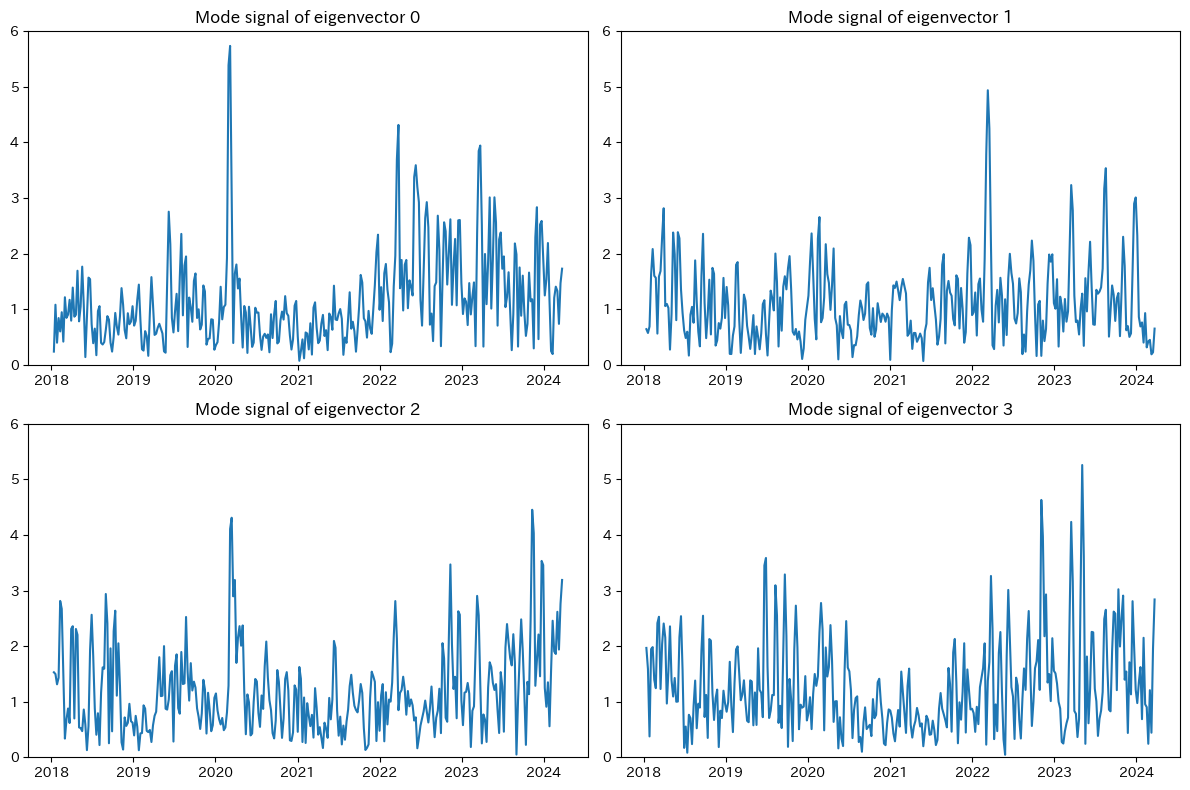

In [416]:
mode_signal = pd.DataFrame(np.abs(alpha_j_t))
mode_signal.index = list(data.index)

cols = 2  # 1行あたりのサブプロットの数
rows = chk.shape[0] // cols + (chk.shape[0] % cols > 0)  # 必要な行数

plt.figure(figsize=(12, rows * 4))

k = 0
for i in list(chk.index):  # 各固有ベクトルに対して
    plt.subplot(rows, cols, k + 1)  # サブプロットの位置を指定
    plt.plot(np.abs(mode_signal.loc[:,i]))
    plt.ylim(0,6)
    plt.title(f'Mode signal of eigenvector {i}')
    k += 1
    
plt.tight_layout()
plt.savefig('img/主要固有ベクトルのモードシグナル.png')
plt.show()

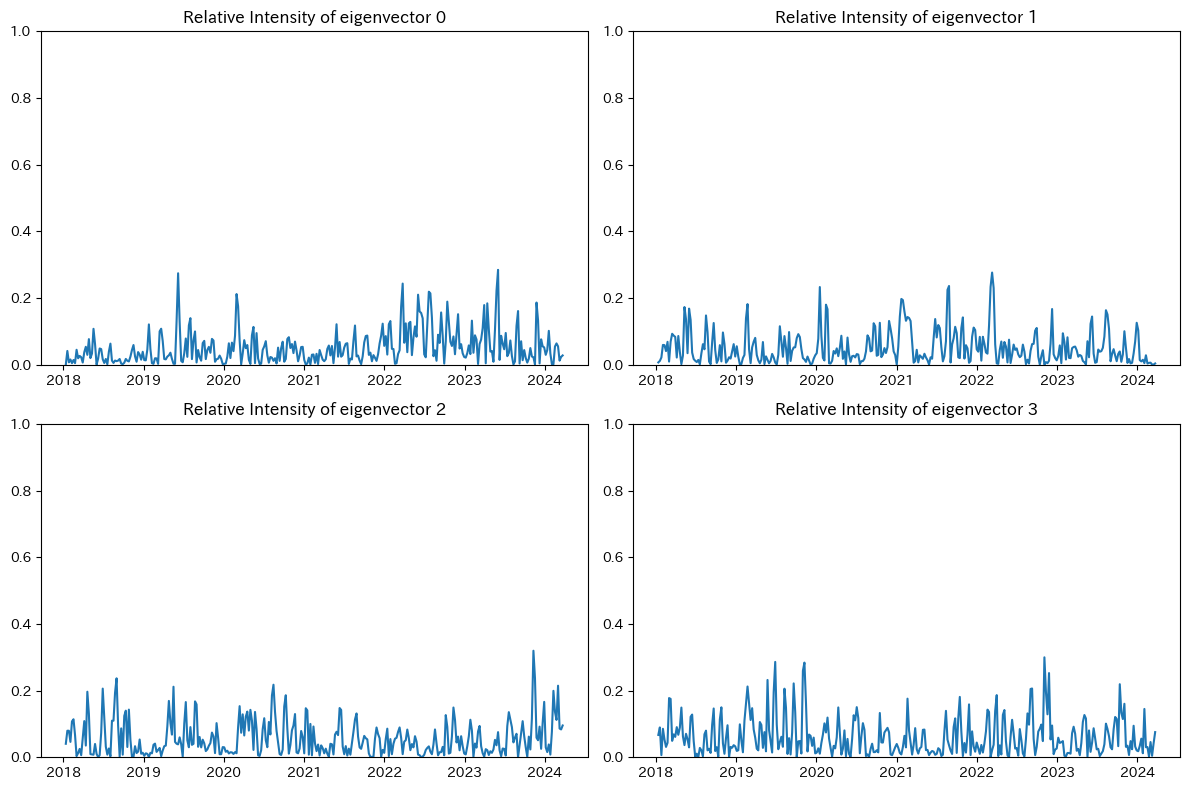

In [435]:
mode_signal2 = pd.DataFrame(np.abs(alpha_j_t)**2)
mode_signal2.index = list(data.index)
intensity = mode_signal2.div(mode_signal2.sum(axis=1),axis=0)

cols = 2  # 1行あたりのサブプロットの数
rows = chk.shape[0] // cols + (chk.shape[0] % cols > 0)  # 必要な行数

plt.figure(figsize=(12, rows * 4))

k = 0
for i in list(chk.index):  # 各固有ベクトルに対して
    plt.subplot(rows, cols, k + 1)  # サブプロットの位置を指定
    plt.plot(intensity.loc[:,i])
    plt.ylim(0,1)
    plt.title(f'Relative Intensity of eigenvector {i}')
    k += 1
    
plt.tight_layout()
plt.savefig('img/主要固有ベクトルの相対強度.png')
plt.show()

In [ ]:

intensity_cum = intensity.cumsum(axis=0).div(intensity.sum(axis=0),axis=1)
intensity_cum.tail()

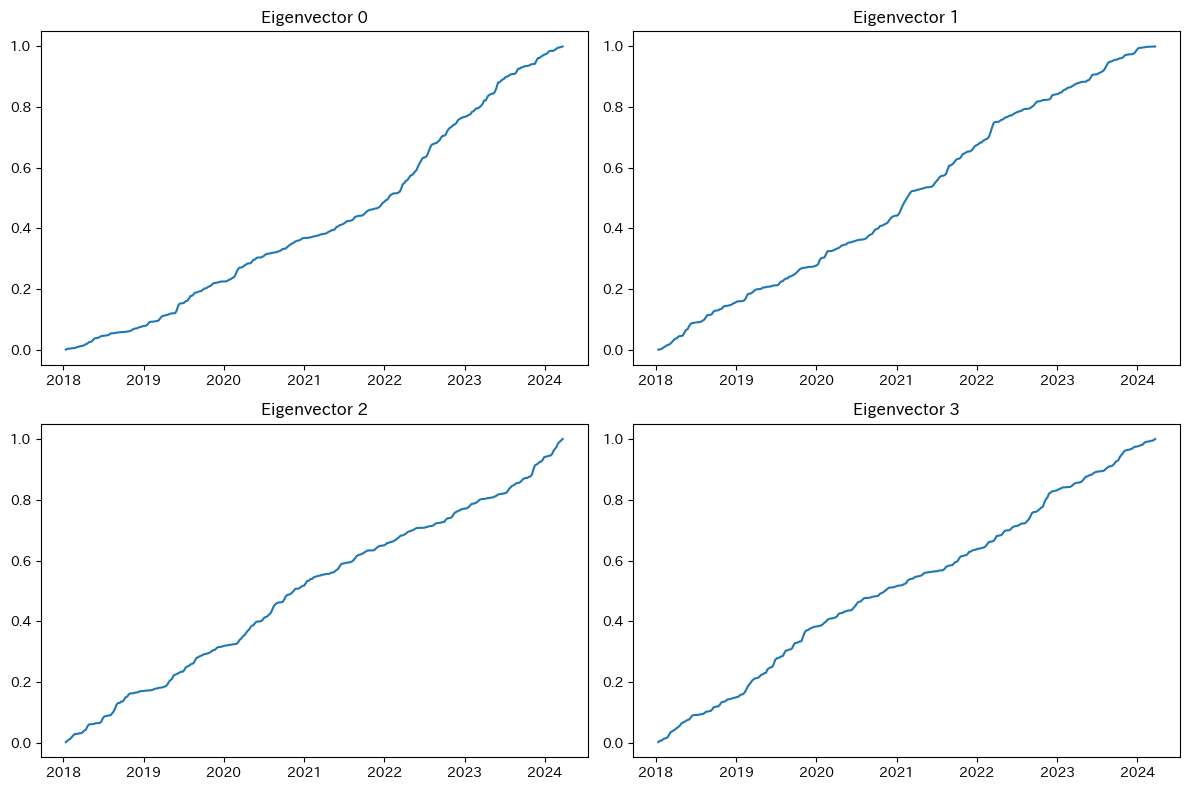

In [197]:
cols = 2  # 1行あたりのサブプロットの数
rows = chk.shape[0] // cols + (chk.shape[0] % cols > 0)  # 必要な行数

plt.figure(figsize=(12, rows * 4))

k = 0
for i in list(chk.index):  # 各固有ベクトルに対して
    plt.subplot(rows, cols, k + 1)  # サブプロットの位置を指定
    plt.plot(intensity.loc[:,i])
    plt.title(f'Eigenvector {i}')
    k += 1
    
plt.tight_layout()
plt.show()

#### RSSの意味

In [ ]:
import numpy as np

def rotational_shuffle(data):
    """
    データを変数ごとに回転的にシャッフルします。
    data: 時系列データ（時間が行、変数が列）
    """
    N, num_vars = data.shape  # Nは時系列の長さ、num_varsは変数の数
    shuffled_data = np.empty_like(data)
    
    for var in range(num_vars):
        tau = np.random.randint(0, N)  # 変数ごとに異なるランダムオフセットtauを生成
        shuffled_data[:, var] = np.roll(data[:, var], -tau)
    
    return shuffled_data

# サンプルデータの生成（例：正弦波 + ノイズ）
t = np.linspace(0, 2 * np.pi, 100)
data = np.vstack([np.sin(t) + np.random.normal(0, 0.1, t.shape[0]) for _ in range(3)]).T

# データを回転的にシャッフル
shuffled_data = rotational_shuffle(data)

# 結果の表示（オプション）
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for i in range(data.shape[1]):
    plt.subplot(data.shape[1], 1, i+1)
    plt.plot(t, data[:, i], label='Original')
    plt.plot(t, shuffled_data[:, i], label='Shuffled')
    plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
pd.DataFrame(data)

In [83]:
np.dot(eigenvecs.T, analytic_signal)

ValueError: shapes (18,18) and (324,18) not aligned: 18 (dim 1) != 324 (dim 0)

In [74]:
correlation_matrix = np.corrcoef(x.T)
evls, evcs = np.linalg.eig(correlation_matrix)
evls

array([2.64018708, 0.28989944, 0.06991348])

In [75]:
evcs = pd.DataFrame(evcs)
evcs.index = list(x.columns)
evcs

,0,1,2
a,0.554525,0.796988,0.239398
b,0.599170,-0.182746,-0.779487
c,0.577493,-0.575685,0.578869


In [80]:
(evcs.loc[:,[0,1]]).dot(evcs.loc[:,[0,1]].T)

,a,b,c
a,0.942688,0.186608,-0.138580
b,0.186608,0.392401,0.451221
c,-0.138580,0.451221,0.664911


In [67]:
np.linalg.norm(evcs[0])

1.0000000000000002

In [71]:
x_ = pd.DataFrame(x.dot(evcs.loc[:,[0,1]]))
x_.columns = ['aa','bb']
x_

,aa,bb
0,5.291379,-0.696413
1,2.298368,-0.534203
2,10.985544,-6.515945
3,3.752424,-3.540840
4,-7.635288,0.834262


In [166]:
# 解析信号 Ψ(t) の準備 (仮のデータ)
# 例: 100個のサンプルポイントを持つ5変数の時系列データ
Psi_t = np.random.rand(100, 5) + 1j * np.random.rand(100, 5)

# 固有ベクトル行列 U の準備 (仮のデータ)
# 例: 5変数のデータに対する5つの固有ベクトル
U = np.random.rand(5, 5) + 1j * np.random.rand(5, 5)

# U の共役転置 U^+ の計算
U_plus = U.conjugate().T

# 各成分 αj(t) の計算
# Ψ(t) に U^+ を掛けることで各時刻tにおける全成分を計算
alpha_j_t = Psi_t.dot(U_plus)

# Ψ(t) の再構成
# αj(t) と U の各列（固有ベクトル）の積の和で元の信号を再構成
Psi_t_reconstructed = alpha_j_t.dot(U.T)  # U.T は U の転置

# 結果の確認
print("再構成された信号 Ψ(t) の形状:", Psi_t_reconstructed.shape)


再構成された信号 Ψ(t) の形状: (100, 5)


In [167]:
pd.DataFrame(Psi_t)

,0,1,2,3,4
0,0.631104+0.637814j,0.949136+0.736625j,0.620000+0.027298j,0.389231+0.913508j,0.995618+0.400793j
1,0.327905+0.063858j,0.301057+0.173806j,0.441352+0.166081j,0.157565+0.623701j,0.764079+0.992138j
2,0.519569+0.816622j,0.298172+0.845265j,0.603441+0.206383j,0.975891+0.908945j,0.507599+0.664239j
3,0.188494+0.998109j,0.966053+0.490901j,0.724917+0.080600j,0.879461+0.712063j,0.659644+0.257662j
4,0.538771+0.636164j,0.265207+0.281989j,0.561749+0.511053j,0.187658+0.189938j,0.131810+0.167586j
...,...,...,...,...,...
95,0.298959+0.830104j,0.697457+0.269373j,0.240262+0.442843j,0.468557+0.041015j,0.835165+0.057739j
96,0.754870+0.141800j,0.512078+0.520213j,0.985218+0.549232j,0.738178+0.001879j,0.637186+0.345411j
97,0.563375+0.293122j,0.555674+0.451922j,0.125863+0.471177j,0.330278+0.538205j,0.547817+0.473494j
98,0.795188+0.962312j,0.674810+0.679646j,0.051777+0.921256j,0.179667+0.243843j,0.171367+0.158163j


In [422]:
mode_signal.iloc[:5,:5]

,0,1,2,3,4
2018-01-12,0.237284,0.640851,1.529583,1.967867,3.417011
2018-01-19,1.080318,0.572337,1.497294,1.587417,0.493788
2018-01-26,0.397118,0.688901,1.312643,0.375268,1.423513
2018-02-02,0.840647,1.626004,1.431248,1.947022,1.239885
2018-02-09,0.599912,2.082731,2.813099,1.982563,2.963400
